In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy import stats
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn import svm, preprocessing
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

%config InlineBackend.figure_format = 'retina' # set 'png' here when working on notebook
%matplotlib inline

In [2]:
df_2006_2010 = pd.read_csv("data/eleicoes_2006_a_2010.csv", index_col = "nome")
df_2014 = pd.read_csv("data/eleicoes_2014.csv", index_col = "nome")
all_data = pd.concat([df_2006_2010, df_2014])
all_data = all_data.drop(columns=["sequencial_candidato"])

In [3]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) # compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [4]:
# aplicando nos dados de 2006 e 2010
all_data = pd.get_dummies(all_data) # dummies
all_data = all_data.fillna(all_data.mean()) # valores ausentes

In [5]:
X_train_2006 = all_data[(all_data["ano"]==2006)]
y_train_2006 = X_train_2006["votos"]
X_train_2006 = X_train_2006.drop(columns=["votos"])
X_train_2006 = X_train_2006.drop(columns=["ano"])

X_test_2010 = all_data[(all_data["ano"]==2010)]
y_test_2010 = X_test_2010["votos"]
X_test_2010 = X_test_2010.drop(columns=["votos"])
X_test_2010 = X_test_2010.drop(columns=["ano"])

X_train_2006_2010 = all_data[(all_data["ano"]!=2014)]
y_train_2006_2010 = X_train_2006_2010["votos"]
X_train_2006_2010 = X_train_2006_2010.drop(columns=["votos"])
X_train_2006_2010 = X_train_2006_2010.drop(columns=["ano"])

X_test_2014 = all_data[(all_data["ano"]==2014)]
y_test_2014 = X_test_2014["votos"]
X_test_2014 = X_test_2014.drop(columns=["votos"])
X_test_2014 = X_test_2014.drop(columns=["ano"])

In [6]:
models = []
models.append(("ridge", Ridge(alpha=10)))
models.append(("Lasso", LassoCV(max_iter=60000000)))
models.append(("KNN", KNeighborsRegressor(n_neighbors=5)))
models.append(("Random", RandomForestRegressor(n_estimators = 50, random_state = 43, max_depth = 8)))

# RMSE

## RMSE no Treino

In [7]:
# RMSE - CrossValidation no Treino
np.random.seed(7)
num_folds = 10

results = []
names = []
media = []

for name, model in models:
    kfold = KFold(n_splits=num_folds)
    # cv_results = -cross_val_score(model, X_train_2006, y_train_2006, cv = kfold, scoring="neg_mean_squared_error")
    cv_results = -cross_val_score(model, X_train_2006_2010, y_train_2006_2010, cv = kfold, scoring="neg_mean_squared_error")
    results.append(cv_results)
    media.append(cv_results.mean())
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ridge: 0.999216 (0.116405)
Lasso: 1.032926 (0.137473)
KNN: 1.113841 (0.116615)
Random: 0.973195 (0.149276)


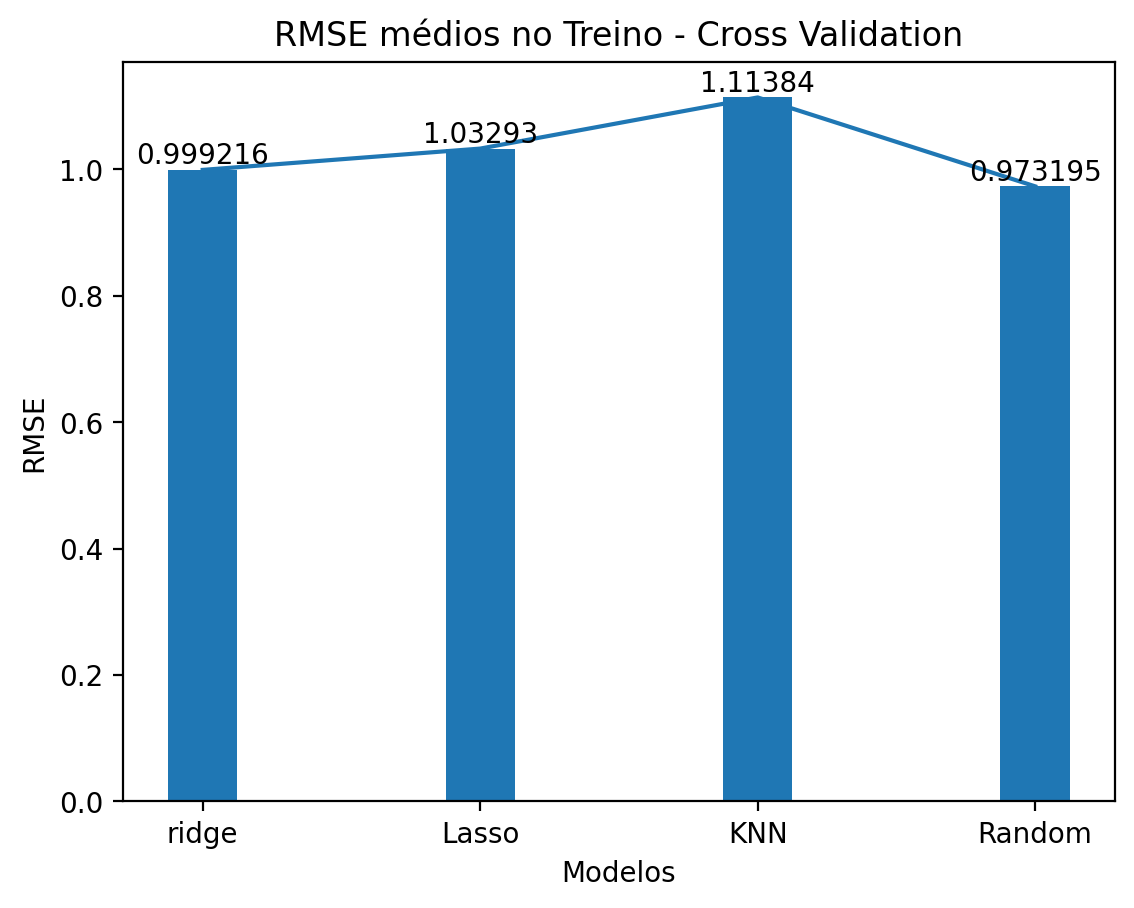

In [8]:
# RMSE - CrossValidation no Treino
fig, ax = plt.subplots()
width = 0.25
b1_ = ax.bar(names, media, width)
ax.bar_label(b1_)
ax.plot(names, media)
ax.set_title("RMSE médios no Treino - Cross Validation")
ax.set_ylabel("RMSE")
ax.set_xlabel("Modelos")
plt.show()

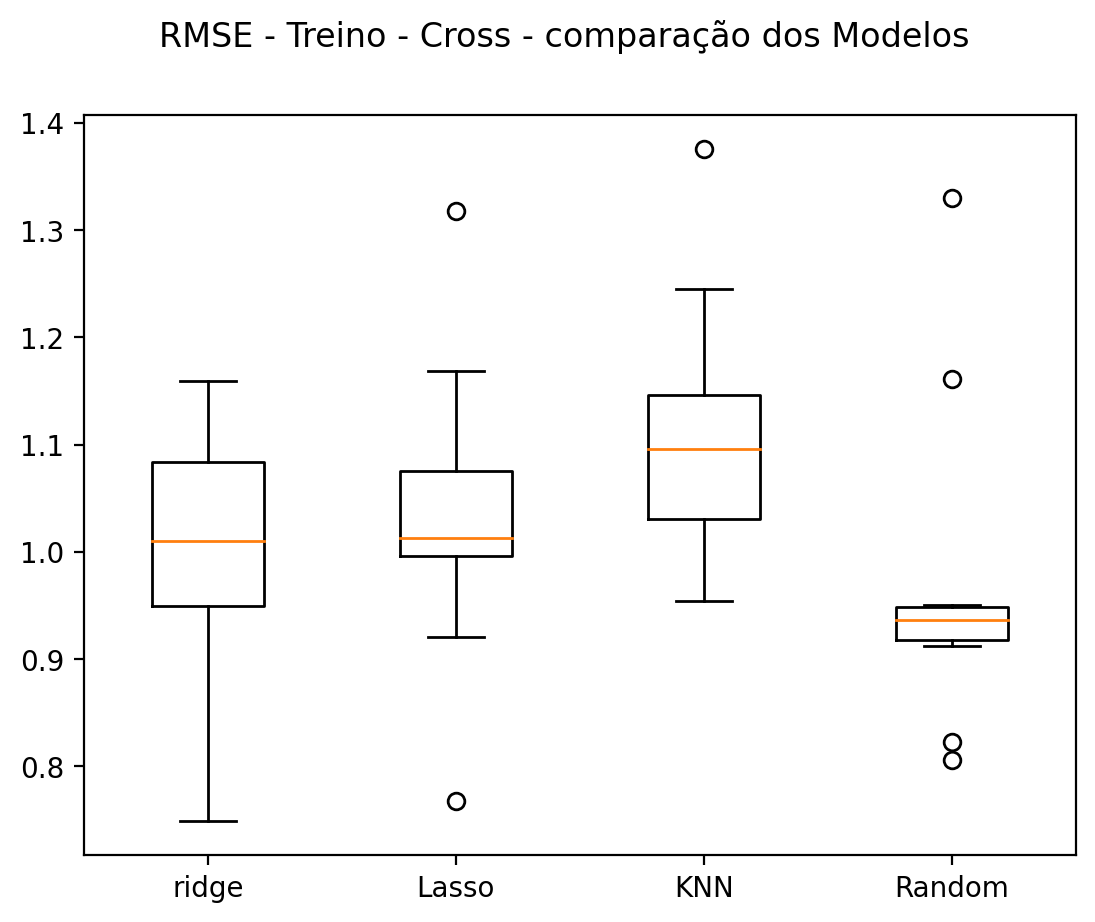

In [9]:
# RMSE - CrossValidation - No Treino
fig = plt.figure()
fig.suptitle("RMSE - Treino - Cross - comparação dos Modelos")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## RMSE no Teste

In [10]:
# RMSE no Teste
np.random.seed(7)
num_folds = 10

results_RMSE_Test = []
names_RMSE_Test = []
media_RMSE_Test = []
print("RMSE no Teste")
for name, model in models:
    model.fit(X_train_2006_2010, y_train_2006_2010)
    y_pred_2014 = model.predict(X_test_2014)
    results_RMSE_Test_ = metrics.mean_squared_error(y_test_2014, y_pred_2014, squared=False)
    results_RMSE_Test.append(results_RMSE_Test_)
    media_RMSE_Test.append(results_RMSE_Test_.mean())
    names_RMSE_Test.append(name)   
    print( "%s: %f" % (name, results_RMSE_Test_))

RMSE no Teste
ridge: 1.805850
Lasso: 1.817806
KNN: 1.857145
Random: 1.833843


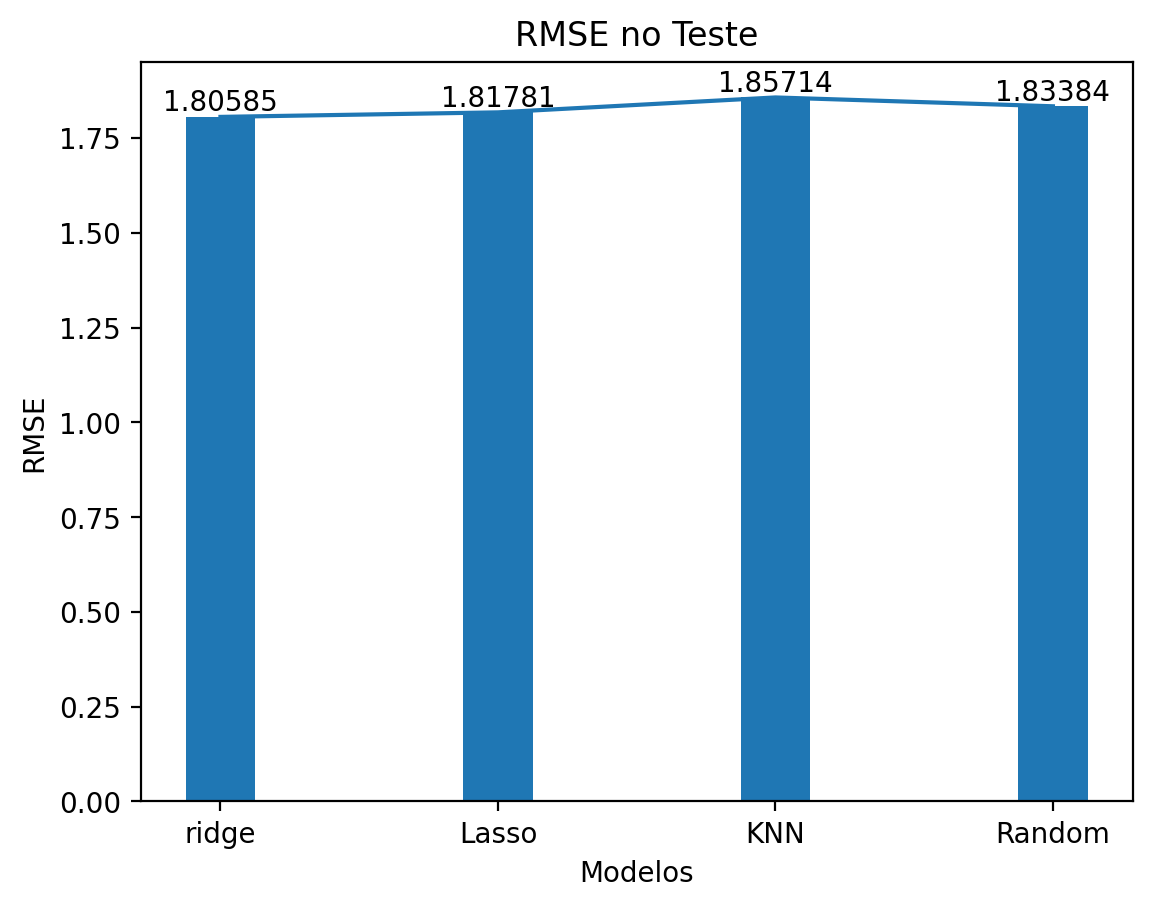

In [27]:
# RMSE - CrossValidation no Treino
fig, ax = plt.subplots()
width = 0.25
b1_ = ax.bar(names_RMSE_Test, media_RMSE_Test, width)
ax.bar_label(b1_)
ax.plot(names_RMSE_Test, media_RMSE_Test)
ax.set_title("RMSE no Teste")
ax.set_ylabel("RMSE")
ax.set_xlabel("Modelos")
plt.show()

In [29]:
## MAE no Teste - Erro médio absoluto

O erro médio absoluto (MAE — do inglês Mean Absoluto Error), mede a média da diferença entre o valor real com o predito. Mas por haver valores positivos e negativos, é adicionado um módulo entre a diferença dos valores. Além disso, esta métrica não é afetada por valores discrepantes — os denominados outliers.

In [36]:
# MAE no Teste
np.random.seed(7)
num_folds = 10

results_MAE_Test = []
names_MAE_Test = []
print("MAE no Treino")
for name, model in models:
    model.fit(X_train_2006_2010, y_train_2006_2010)
    y_pred_2014 = model.predict(X_test_2014)
    results_MAE_Test_ = metrics.mean_absolute_error(np.expm1(y_test_2014), np.expm1(y_pred_2014))
    results_MAE_Test.append(results_MAE_Test_)
    names_MAE_Test.append(name)   
    print( "%s: %f" % (name, results_MAE_Test_))

MAE no Treino
ridge: 12259.976454
Lasso: 11987.634283
KNN: 10346.223414
Random: 9522.841098


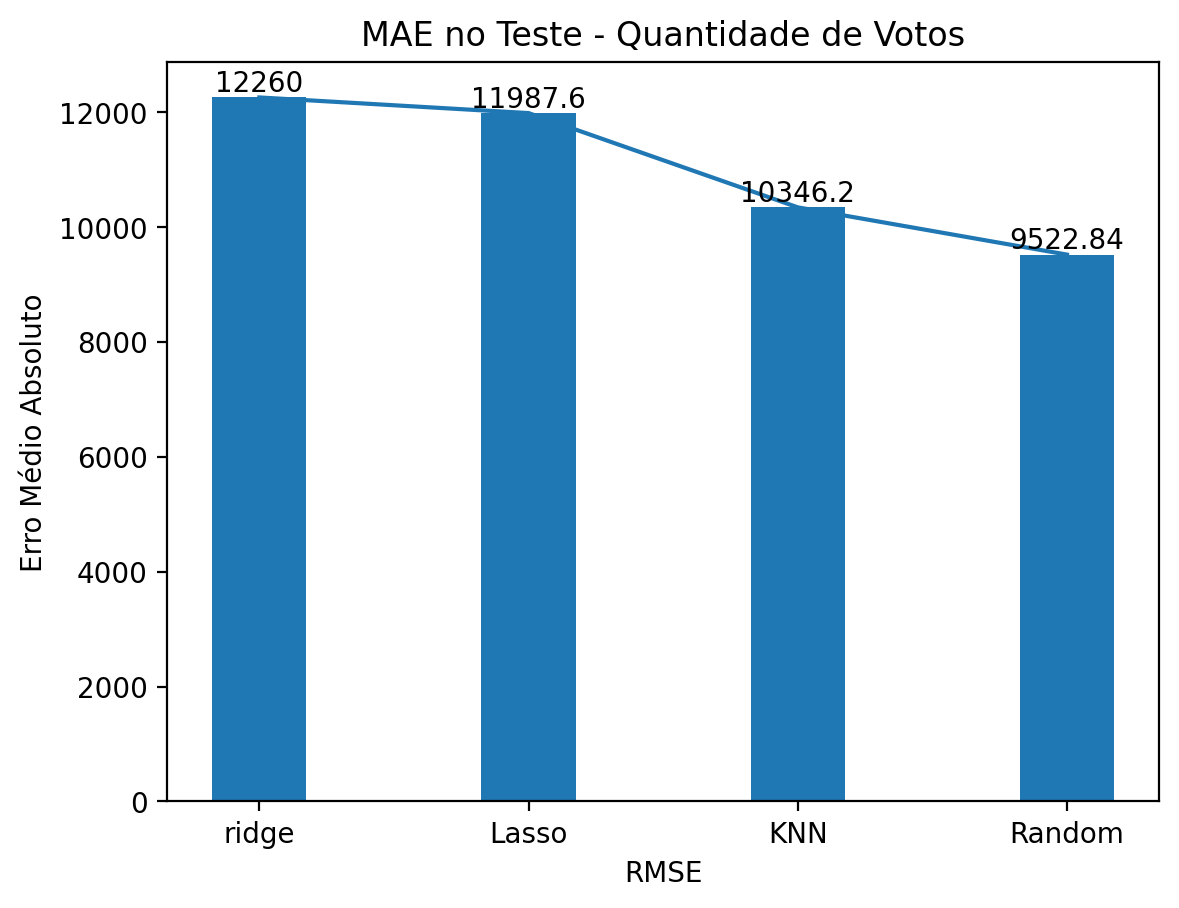

In [44]:
# MAE no Teste
fig, ax = plt.subplots()
width = 0.35
bl = ax.bar(names_MAE_Test, results_MAE_Test, width)
ax.bar_label(bl)
ax.plot(names_MAE_Test, results_MAE_Test)
ax.set_ylabel("Erro Médio Absoluto")
ax.set_title("MAE no Teste - Quantidade de Votos")
ax.set_xlabel("RMSE")
plt.show()

Ou seja ele teve um erro médio absoluto, no melhor modelo, de 9.522 votos. 

# Resultado

In [40]:
model_ = RandomForestRegressor(n_estimators = 50, random_state = 43, max_depth = 8)
model_.fit(X_train_2006_2010, y_train_2006_2010)
y_pred = model_.predict(X_test_2014)

In [41]:
solution = pd.DataFrame({"nome": X_test_2014.index,"votos":np.expm1(y_test_2014).astype(int)})
solution.to_csv("real_2014.csv")
solution = pd.DataFrame({"nome": X_test_2014.index,"votos preditos":np.expm1(y_pred).astype(int)})
solution.to_csv("pred_2014.csv")
solution = pd.DataFrame({"nome": y_test_2014.index,"votos preditos":np.expm1(y_pred).astype(int),"votos real":np.expm1(y_test_2014).astype(int)})
solution.to_csv("pred_e_real_2014.csv")

Os modelos comparados foram: Ridge, Lasso, KNN e RandomForestRegressor.

O modelo seleciondo foi o RandomForestRegressor, levando em consideração o RMSE.

O modelo final escolhido foi o RandomForestRegressor.

Uma predição com dados de 2014 foi gerado a partir do modelo construído.